In [4]:
from quspin.operators import hamiltonian
from quspin.operators import commutator# Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np # generic math functions
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def Ham_nonint(L):
    basis = spin_basis_1d(L)
    hz=(np.sqrt(5)+1)/4 #parameters used by Kim and Huse
    hx=(np.sqrt(5)+5)/8
    J=1.0
    hz_arr = [[hz,i] for i in range(L)] 
    hx_arr = [[hx,i] for i in range(L)] 
    J_arr = [[J,i,(i+1)] for i in range(L-1)] # OBC [[J,i,(i+1)%L] for i in range(L)] # PBC
    
    # static and dynamic lists
    static = [["zz",J_arr],["z",hz_arr], ["x",hx_arr] ]
    dynamic =[]
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return H

def Ham_int_antiferro(L,hz):
    basis = spin_basis_1d(L)
    J=1.0
    hz_arr = [[hz,i] for i in range(L)] # OBC
    J_arr = [[J,i,(i+1)] for i in range(L-1)] # OBC [[J,i,(i+1)%L] for i in range(L)] # PBC
    
    # static and dynamic lists
    static = [["zz",J_arr],["x",hz_arr]]
    dynamic =[]
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return H

In [3]:
def del_lambda_Ham(L):
    basis = spin_basis_1d(L)  
    hx_lamb=1.0
    hx_lamb_arr = [[hx_lamb,i] for i in range(L)] # OBC
    static_lamb = [["x",hx_lamb_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return op_lamb

def norm(A_lamb):    
    return np.linalg.norm(A_lamb, 'fro')

def guage_potent_mu(Ham,L, mu):
    E,V= Ham.eigh()
    op_lamb= del_lambda_Ham(L)
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    num_lamb = np.dot(V,np.dot(op_lamb.toarray(),np.conj(V)))
    A_lamb = -1j*num_lamb*wij/(wij**2+ mu**2)
    return A_lamb

### Analytical formula: trace of $[H, \partial_{\lambda}H]$

In [10]:
#integrbale model
L=8
hz=5
Ham=Ham_int_antiferro(L,hz)
partial_lamb_H=del_lambda_Ham(L)
comm=commutator(Ham,partial_lamb_H)
mat=((-1j*comm)**2).toarray()
print np.trace(mat)/2**8, 4*2*(L-1)

(56+0j) 56


In [13]:
#non-integrbale model
L=4
Ham=Ham_nonint(L)
partial_lamb_H=del_lambda_Ham(L)
comm=commutator(Ham,partial_lamb_H)
mat=((-1j*comm)**2).toarray()
hz=(np.sqrt(5)+1)/4 
print " num,th:", np.trace(mat)/2**4, 4*(L*hz**2+2*(L-1))

 num,th: (34.472135955+0j) 34.472135955


### Numerical value: integrable

In [15]:
muTot=100
L=4
hz=5
norm_arr_int=np.zeros(muTot)
mu_arr=np.logspace(-2,40,muTot)
H=Ham_int_antiferro(L,hz)
for i in range(muTot):
    mu=mu_arr[i]
    A_lamb=guage_potent_mu(H,L,mu)
    norm_arr_int[i]=norm(A_lamb)

In [44]:
E,V= H.eigh()
wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
index_lower = np.tril_indices(2**L,-1)
wij_arr=wij[index_lower]
print min(wij_arr), max(wij_arr)

0.133591984952 40.3002473846


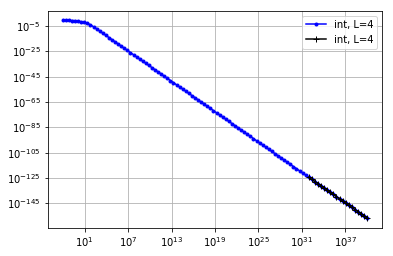

In [50]:
plt.loglog(mu_arr,norm_arr_int**2/2**4, 'b.-', label='int, L=4')
plt.loglog(mu_arr[80:],norm_arr_int[80:]**2/2**4, 'k+-', label='int, L=4')
#plt.loglog(mu_arr_L6,norm_arr_nonintL6/2**6, 'r.-', label='Non-int, L=6')
#plt.loglog(mu_arr_L6[40:100],norm_arr_nonintL6[40:100]/2**6, 'k+-', label='Non-int, L=6')
#plt.loglog(mu_arr_L8,norm_arr_nonintL8/2**8, 'g.-', label='Non-int, L=8')
#plt.loglog(mu_arr_L8[20:50],norm_arr_nonintL8[20:50]/2**8, 'k+-', label='Non-int, L=8')
plt.legend(loc='best')
plt.grid()

In [31]:
from scipy.optimize import curve_fit
def gfunc(x, a,c): #logfunction
    return a+ c*x
def org_func(x, a,c):
    return a*x**c
xdata =mu_arr[80:]
ydata = norm_arr_int[80:]**2/2**4
popt, pcov = curve_fit(gfunc, np.log(xdata), np.log(ydata))
print popt, np.diag(pcov)
a_in,b_in=popt
L=4
print " num,th:", np.exp(a_in), 4*2*(L-1), np.exp(a_in)/(4*2*(L-1)), np.log(82)
print " log of num,th:", a_in, np.log(4*2*(L-1))

[ 7.58475071 -4.        ] [  5.84839830e-27   8.48648629e-31]
 num,th: 1967.9559844 24 81.9981660167 4.40671924726
 log of num,th: 7.58475071171 3.17805383035


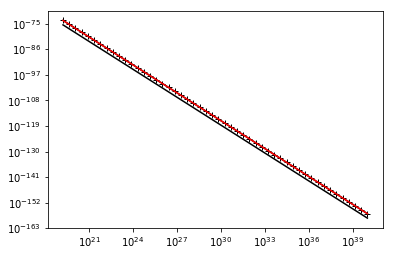

In [21]:
plt.loglog(mu_arr[50:100],norm_arr_int[50:100]**2/2**4, 'k+-', label='Non-int, L=4')
plt.loglog(mu_arr[50:100],org_func(mu_arr[50:100], np.exp(a_in),b_in,), 'r-', label='Non-int, L=4')
plt.loglog(mu_arr[50:100],org_func(mu_arr[50:100], 24.0,b_in,), 'k-', label='Non-int, L=4')

### Numerical value: non-integrable

In [60]:
muTot=100
L=6
norm_arr_nonint=np.zeros(muTot)
mu_arr=np.logspace(-5,40,muTot)
H=Ham_nonint(L)
for i in range(muTot):
    mu=mu_arr[i]
    A_lamb=guage_potent_mu(H,L,mu)
    norm_arr_nonint[i]=norm(A_lamb)

In [79]:
L=6
H=Ham_nonint(L)
E,V= H.eigh()
wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
index_lower = np.tril_indices(2**L,-1)
wij_arr=wij[index_lower]
print min(wij_arr), max(wij_arr), len(E)

0.00172247690936 18.2585719543 64


In [56]:
L=12
H=Ham_nonint(L)
E,V= H.eigh()
wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
index_lower = np.tril_indices(2**L,-1)
wij_arr=wij[index_lower]
print min(wij_arr), max(wij_arr)

2.30793233413e-08 37.5791979082


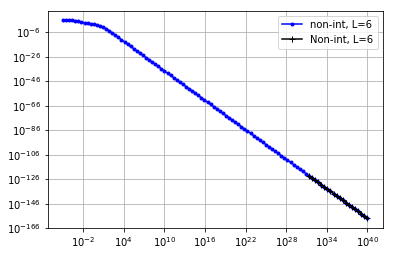

In [61]:
plt.loglog(mu_arr,norm_arr_nonint**2/2**6, 'b.-', label='non-int, L=6')
plt.loglog(mu_arr[80:],norm_arr_nonint[80:]**2/2**6, 'k+-', label='Non-int, L=6')
#plt.loglog(mu_arr_L6,norm_arr_nonintL6/2**6, 'r.-', label='Non-int, L=6')
#plt.loglog(mu_arr_L6[40:100],norm_arr_nonintL6[40:100]/2**6, 'k+-', label='Non-int, L=6')
#plt.loglog(mu_arr_L8,norm_arr_nonintL8/2**8, 'g.-', label='Non-int, L=8')
#plt.loglog(mu_arr_L8[20:50],norm_arr_nonintL8[20:50]/2**8, 'k+-', label='Non-int, L=8')
plt.legend(loc='best')
plt.grid()

In [78]:
from scipy.optimize import curve_fit
def gfunc(x, a,c): #logfunction
    return a+ c*x
def org_func(x, a,c):
    return a*x**c
xdata =mu_arr[80:]
ydata = norm_arr_nonint[80:]**2/2**6
popt, pcov = curve_fit(gfunc, np.log(xdata), np.log(ydata))
print popt, np.diag(pcov)
a_in,b_in=popt
hz=(np.sqrt(5)+1)/4 
L=6
print " num,th:", np.exp(a_in), 4*(L*hz**2+2*(L-1)), np.exp(a_in)/(4*(L*hz**2+2*(L-1)))
print " log of num,th:", a_in, np.log(4*(L*hz**2+2*(L-1))) 

[ 5.20864352 -4.        ] [  1.17068595e-26   1.72495694e-30]
 num,th: 182.84586303 55.7082039325 3.28220710996
 log of num,th: 5.2086435194 4.02012742392


In [64]:
def alpha_fun(norm_gauge_potent,mu,L):
    return mu**4*(norm_gauge_potent**2/2**L)

In [77]:
L=6
for i in range(20):
    print i,alpha_fun(norm_arr_nonint[10+i],mu_arr[10+i],L), mu_arr[10+i]

0 0.0222389526003 0.351119173422
1 0.469545224312 1.0
2 7.31099861692 2.84803586844
3 56.3422186252 8.1113083079
4 143.080243174 23.1012970008
5 176.678601996 65.7933224658
6 182.059703454 187.381742286
7 182.748531661 533.669923121
8 182.833857299 1519.91108295
9 182.844382812 4328.76128108
10 182.845680541 12328.4673944
11 182.845840532 35111.9173422
12 182.845860256 100000.0
13 182.845862688 284803.586844
14 182.845862988 811130.83079
15 182.845863025 2310129.70008
16 182.84586303 6579332.24658
17 182.84586303 18738174.2286
18 182.84586303 53366992.3121
19 182.84586303 151991108.295


### Numerical value: non-integrable with periodic boundary condition